In [177]:
from utils.SaxImage import SAXImage
from utils.LaxImage import LAXImage
import SimpleITK as sitk
import os
import numpy as np
import cv2
from skimage import transform
from torchvision import transforms
import torch

subject = "/home/ngaggion/Documentos/Leeds/Dataset/Subjects/1030914/image/time001"

SAX_PATH = os.path.join(subject, "SAX")
LAX_PATH = os.path.join(subject, "LAX")
LAX_2CH_PATH = os.path.join(LAX_PATH, "2CH", '0001')
LAX_3CH_PATH = os.path.join(LAX_PATH, "3CH", '0001')
LAX_4CH_PATH = os.path.join(LAX_PATH, "4CH", '0001')

SaxImage = SAXImage(SAX_PATH)
SaxImage_array = SaxImage.pixel_array()
SaxImage_array = (SaxImage_array - np.min(SaxImage_array)) / (np.max(SaxImage_array) - np.min(SaxImage_array))

try:
    Lax2CH = LAXImage(LAX_2CH_PATH)
    Lax2CH_array = Lax2CH.pixel_array()
    Lax2CH_array = (Lax2CH_array - np.min(Lax2CH_array)) / (np.max(Lax2CH_array) - np.min(Lax2CH_array))
except:
    Lax2CH = None
    Lax2CH_array = np.zeros((224, 224, 1))

try:
    Lax3CH = LAXImage(LAX_3CH_PATH)
    Lax3CH_array = Lax3CH.pixel_array()
    Lax3CH_array = (Lax3CH_array - np.min(Lax3CH_array)) / (np.max(Lax3CH_array) - np.min(Lax3CH_array))
except:
    Lax3CH = None
    Lax3CH_array = np.zeros((224, 224, 1))
    
try:
    Lax4CH = LAXImage(LAX_4CH_PATH)
    Lax4CH_array = Lax4CH.pixel_array()
    Lax4CH_array = (Lax4CH_array - np.min(Lax4CH_array)) / (np.max(Lax4CH_array) - np.min(Lax4CH_array))
except:
    Lax4CH = None
    Lax4CH_array = np.zeros((224, 224, 1))

mesh = np.load(os.path.join(subject.replace("image", "mesh"), "surface.npy"))

sample = {'SAX': SaxImage, 'LAX2CH': Lax2CH, 'LAX3CH': Lax3CH, 'LAX4CH': Lax4CH, 'Mesh': mesh,
          'Sax_Array': SaxImage_array, 'Lax2CH_Array': Lax2CH_array, 'Lax3CH_Array': Lax3CH_array, 'Lax4CH_Array': Lax4CH_array}

In [178]:
from utils.dataset import (CardiacImageMeshDataset, PadArraysToSquareShape, CropArraysToSquareShape, 
                            RandomCropBoth, RandomScalingBoth, AugColor, Rotate,
                            ToTorchTensors, AlignMeshWithSaxImage)
 
 
all_transforms = transforms.Compose([
                                    AlignMeshWithSaxImage(),
                                    RandomCropBoth(),
                                    AugColor(0.5),
                                    Rotate(5),
                                    ToTorchTensors()
                                ])

In [179]:
sample = all_transforms(sample)

Mesh height:  49.65160844012617
Mesh width:  53.005234284549
New sax height:  193
New sax width:  194


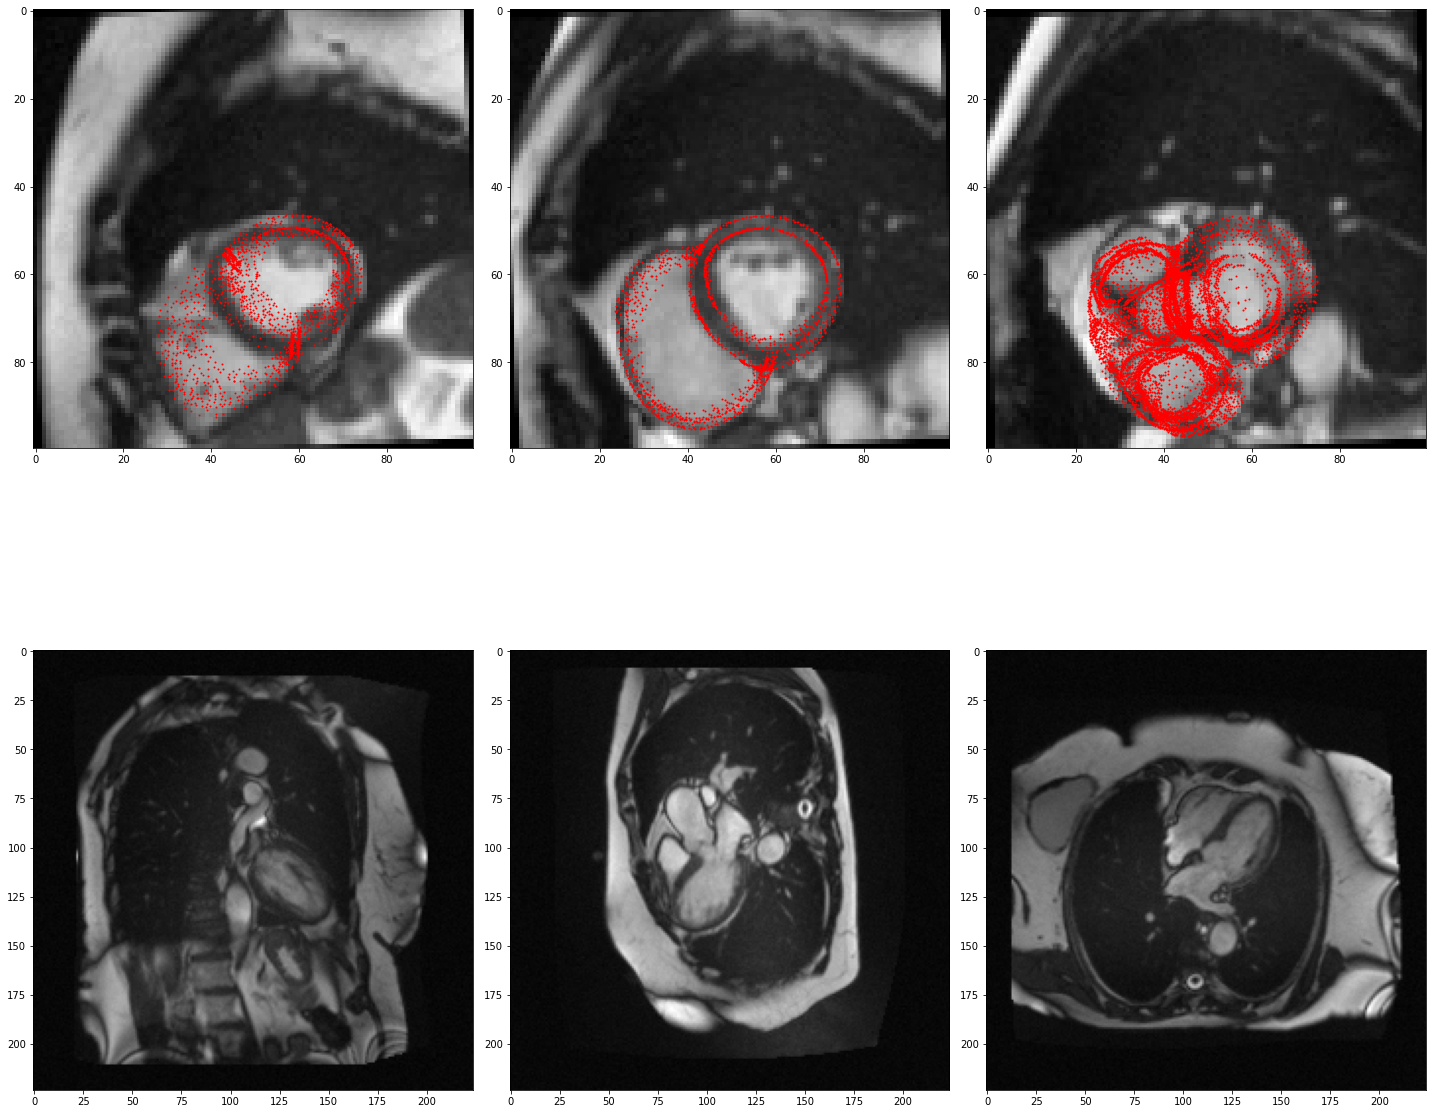

In [180]:
import matplotlib.pyplot as plt

mesh = sample["Mesh"]
m1 = mesh[:, 2] < (7 / 16) * (mesh[:, 2] > (5 / 16))
m1 = mesh[m1, :] * 100

m2 = mesh[:, 2] < (9 / 16) * (mesh[:, 2] > (7 / 16))
m2 = mesh[m2, :] * 100

m3 = mesh[:, 2] < (11 / 16) * (mesh[:, 2] > (9 / 16))
m3 = mesh[m3, :] * 100

plt.figure(figsize=(20, 20))

plt.subplot(2, 3, 1)
plt.imshow(sample["Sax_Array"][0, 7, :, :].cpu().numpy(), cmap="gray")
plt.scatter(m1[:, 0], m1[:, 1], s=1, c="red")

plt.subplot(2, 3, 2)
plt.imshow(sample["Sax_Array"][0, 9, :, :].cpu().numpy(), cmap="gray")
plt.scatter(m2[:, 0], m2[:, 1], s=1, c="red")

plt.subplot(2, 3, 3)
plt.imshow(sample["Sax_Array"][0, 11, :, :].cpu().numpy(), cmap="gray")
plt.scatter(m3[:, 0], m3[:, 1], s=1, c="red")

plt.subplot(2, 3, 4)
plt.imshow(sample["Lax2CH_Array"][0, :, :].cpu().numpy(), cmap="gray")

plt.subplot(2, 3, 5)
plt.imshow(sample["Lax3CH_Array"][0, :, :].cpu().numpy(), cmap="gray")

plt.subplot(2, 3, 6)
plt.imshow(sample["Lax4CH_Array"][0, :, :].cpu().numpy(), cmap="gray")

plt.tight_layout()
